In [1]:
import sys

import matplotlib.pyplot as plt
## save variables
import pickle
## folder names
from glob import glob
## standard libraries
import numpy as np
## division for train and test
from sklearn.model_selection import train_test_split
##
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D ,Convolution2D, MaxPooling2D
from keras import backend as K
K.set_image_dim_ordering('th')
from keras.optimizers import SGD
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
def plotConfusionMatrix(predictions, true_labels, labels):
    k = true_labels.shape[1]
    n = true_labels.shape[0]
    confusion_matrix = np.zeros((k,k))

    for l in range(n):
        decision = np.zeros(k)
        j = np.argmax(predictions[l])
        decision[j] = 1
        i = np.argmax(true_labels[l])
        confusion_matrix[i,j] +=1
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion_matrix)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
def kcenter(data, k):
    if k == data.shape[0]:
        return data
    '''
    input:
    data = numpy ndarray of shape (n_examples, a, b, c)
    k : integer

    output:
    data reduced -> the new shape will be (k, a, b, c)
    '''

    n_examples = data.shape[0]


    P = np.reshape(data, (n_examples, -1))
    P_minus_S = [p for p in P]
    idx_rnd = np.random.randint(0, len(P)-1)
    S = [P[idx_rnd]]
    dist_near_center = [np.linalg.norm(P[i]-S[0]) for i in range(len(P))]

    for i in range(k-1):
        progbar(i, k-2, 50)
        #if i%150==0 : print("progress: " + str(i/(k-1)*100) + " %")
        new_center_idx = max(enumerate(dist_near_center), key=lambda x: x[1])[0] # argmax operation
        S.append(P[new_center_idx])

    for j in range(len(P)):
        if j != new_center_idx:
            dist = np.linalg.norm(P[j]-S[-1])
            if dist < dist_near_center[j]:
                dist_near_center[j] = dist
        else:
            dist_near_center[j] = 0
    print()

    #numpy darray tranformation
    data_vector_reduced = np.array(S)
    #Shape back
    dimensions = (k, data.shape[1], data.shape[2])
    data_back = np.reshape(data_vector_reduced, dimensions)

    return data_back


def kcenter_idx(data, k):
    if k == data.shape[0]:
        return range(k)
    '''
    input:
        data = numpy ndarray of shape (n_examples, a, b, c)
        k : integer
        
    output:
        data reduced -> the new shape will be (k, a, b, c)
    '''
    
    n_examples = data.shape[0]
    
    
    P = np.reshape(data, (n_examples, -1))
    P_minus_S = [p for p in P]
    idx_rnd = np.random.randint(0, len(P)-1)
    center_idx = [idx_rnd]
    S = [P[idx_rnd]]
    dist_near_center = [np.linalg.norm(P[i]-S[0]) for i in range(len(P))]

    for i in range(k-1):
        progbar(i, k-2, 50)
        #if i%150==0 : print("progress: " + str(i/(k-1)*100) + " %")
        new_center_idx = max(enumerate(dist_near_center), key=lambda x: x[1])[0] # argmax operation
        S.append(P[new_center_idx])
        center_idx.append(new_center_idx)
        
        for j in range(len(P)):
            if j != new_center_idx:
                dist = np.linalg.norm(P[j]-S[-1])
                if dist < dist_near_center[j]:
                    dist_near_center[j] = dist
            else:
                dist_near_center[j] = 0
    print()
    
    #numpy darray tranformation
    data_vector_reduced = np.array(S)
    #Shape back
    dimensions = (k, data.shape[1], data.shape[2])
    data_back = np.reshape(data_vector_reduced, dimensions)
    
    return center_idx


def progbar(curr, total, full_progbar):
    frac = curr/total
    filled_progbar = round(frac*full_progbar)
    print('\r', '='*filled_progbar + '-'*(full_progbar-filled_progbar), '[{:>7.2%}]'.format(frac), end='')

def train_test_creator(dic, down_size = 1, test_size = 0.2):
    X = []
    Y = []
    if type(dic)==dict:
        length = len(dic)
        for count, key in enumerate(dic):
            tmp = dic[key]
            tmp = tmp[kcenter_idx(tmp, round(tmp.shape[0]/down_size)),:,:]
            label = np.array(count)
            label = np.resize(label, (tmp.shape[0],1))
            X.append(tmp)
            Y.append(label)
            #print(key, ' ', count)
    else:
        return -1
    X = np.vstack(X)
    Y = np.vstack(Y)
    
    #X = np.reshape(X, ( X.shape[0],1, X.shape[1], X.shape[2]))
    Y = np_utils.to_categorical(Y, np.max(Y)+1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
    X_train = np.reshape(X_train, ( X_train.shape[0],1, X_train.shape[1], X_train.shape[2]))
    X_test = np.reshape(X_test, ( X_test.shape[0], 1, X_test.shape[1], X_test.shape[2]))
    return X_train, X_test, y_train, y_test 

In [3]:
#with open('variables/rawDict.pkl', 'rb') as f:  
    #rawDict = pickle.load(f)
with open('variables/noiseDict.pkl', 'rb') as f:  
    noiseDict = pickle.load(f)    
with open('variables/mfccDict.pkl', 'rb') as f:  
    mfccDict = pickle.load(f)
with open('variables/fbankDict.pkl', 'rb') as f:  
    fbankDict = pickle.load(f)    


In [4]:
coreKey = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero",
           "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

numbers = {'one', 'two', 'three','four','five','six','seven','eight','nine'}
words = {"yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero"}
X_train, X_test, y_train, y_test = train_test_creator({k: mfccDict[k] for k in mfccDict.keys() & words})

In [5]:
cnn = Sequential()

cnn.add(Convolution2D(64, (5,4),  strides = (1,1), padding="valid",  activation="relu",
                      input_shape=(1, X_train.shape[2], X_train.shape[3])))

cnn.add(MaxPooling2D(pool_size=(3,2)))

cnn.add(Convolution2D(32, (3,2),  strides = (1,1), padding="valid", activation="relu"))
#cnn.add(MaxPooling2D(pool_size=(2,2)))
      
cnn.add(Convolution2D(16, (2,2),  strides = (1,1), padding="valid", activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(50, activation="relu"))
cnn.add(Dropout(0.35))

#cnn.add(Dense(30, activation="sigmoid"))
#cnn.add(Dropout(0.35))

cnn.add(Dense(y_train.shape[1], activation="softmax"))

# define optimizer and objective, compile cnn

cnn.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 95, 10)        1344      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 31, 5)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 29, 4)         12320     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 28, 3)         2064      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 14, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 224)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                11250     
__________

In [ ]:
epoch = 30
cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
cnn.fit(X_train, y_train, epochs=epoch, validation_data=(X_test, y_test), batch_size=round(X_train.shape[0]/250))

Train on 20846 samples, validate on 5212 samples
Epoch 1/30


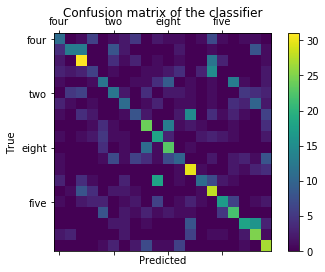

948/948 [==============================] - 0s 107us/step


[1.9623162585471752, 0.3765822782295163]

In [66]:
preds = cnn.predict(X_test)
plotConfusionMatrix(preds,y_test,list(toFit))
cnn.evaluate(X_test,y_test)